In [53]:
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets

In [54]:
# CUDA 가용성 확인
!nvidia-smi

# 필요한 라이브러리 설치
!apt-get update
!apt-get install -y cmake

# GitHub 저장소 클론
!git clone https://github.com/ysl1016/CUDADigitFilter.git
%cd CUDADigitFilter

Mon Jan 27 08:31:07 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [55]:
%cd /content
!rm -rf CUDADigitFilter
!git clone https://github.com/ysl1016/CUDADigitFilter.git
%cd CUDADigitFilter

/content
Cloning into 'CUDADigitFilter'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 156 (delta 83), reused 102 (delta 42), pack-reused 0 (from 0)
Receiving objects: 100% (156/156), 30.74 KiB | 1.71 MiB/s, done.
Resolving deltas: 100% (83/83), done.
/content/CUDADigitFilter


In [56]:
%%writefile /content/CUDADigitFilter/CMakeLists.txt
cmake_minimum_required(VERSION 3.10)
project(mnist_filter CUDA CXX)

set(CMAKE_CUDA_ARCHITECTURES 75)

find_package(OpenCV REQUIRED)

include_directories(${OpenCV_INCLUDE_DIRS})
include_directories(${CMAKE_SOURCE_DIR}/include)

set(CMAKE_CUDA_STANDARD 14)
set(CMAKE_CUDA_STANDARD_REQUIRED ON)

if(POLICY CMP0104)
  cmake_policy(SET CMP0104 NEW)
endif()

add_executable(mnist_filter
    src/main.cu
    src/mnist_loader.cu
    src/filters.cu
    src/utils.cu
)

set_target_properties(mnist_filter PROPERTIES
    CUDA_SEPARABLE_COMPILATION ON
)

target_link_libraries(mnist_filter ${OpenCV_LIBS})

Overwriting /content/CUDADigitFilter/CMakeLists.txt


In [57]:
%cd /content/CUDADigitFilter
!rm -rf CMakeFiles CMakeCache.txt
!cmake .
!make

/content/CUDADigitFilter
-- The CUDA compiler identification is NVIDIA 12.2.140 with host compiler GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting CUDA compiler ABI info
-- Detecting CUDA compiler ABI info - done
-- Check for working CUDA compiler: /usr/local/cuda/bin/nvcc - skipped
-- Detecting CUDA compile features
-- Detecting CUDA compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenCV: /usr (found version "4.5.4")
-- Configuring done (2.6s)
-- Generating done (0.0s)
-- Build files have been written to: /content/CUDADigitFilter
[ 16%] Building CUDA object CMakeFiles/mnist_filter.dir/src/main.cu.o
[ 33%] Building CUDA object CMakeFiles/mnist_filter.dir/src/mnist_loader.cu.o
[ 50%] Building CUDA object CMakeFiles/mnist_filter.dir/src/filters.cu.o
[ 66%] Building CUDA o

In [58]:
import tensorflow as tf
import numpy as np

# 현재 디렉토리 확인 및 이동
%cd /content/CUDADigitFilter

# 데이터 디렉토리 생성
!mkdir -p data/mnist

# MNIST 데이터셋 다운로드
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# train 이미지 데이터 저장
with open('data/mnist/train-images-idx3-ubyte', 'wb') as f:
    # 헤더 작성 (magic number, 이미지 수, 행, 열)
    f.write(np.array([0x00000803, len(x_train), 28, 28], dtype='>i4').tobytes())
    # 이미지 데이터 작성
    f.write(x_train.astype(np.uint8).tobytes())

# test 이미지 데이터 저장
with open('data/mnist/t10k-images-idx3-ubyte', 'wb') as f:
    # 헤더 작성 (magic number, 이미지 수, 행, 열)
    f.write(np.array([0x00000803, len(x_test), 28, 28], dtype='>i4').tobytes())
    # 이미지 데이터 작성
    f.write(x_test.astype(np.uint8).tobytes())

/content/CUDADigitFilter


In [59]:
def check_mnist_data():
    print("Checking MNIST data file...")
    with open('data/mnist/train-images-idx3-ubyte', 'rb') as f:
        # 헤더 읽기
        magic = int.from_bytes(f.read(4), byteorder='big')
        num_images = int.from_bytes(f.read(4), byteorder='big')
        rows = int.from_bytes(f.read(4), byteorder='big')
        cols = int.from_bytes(f.read(4), byteorder='big')

        print(f"\nHeader Information:")
        print(f"Magic number: {hex(magic)}")
        print(f"Number of images: {num_images}")
        print(f"Image size: {rows}x{cols}")

        print("\nChecking first 10 images:")
        # 첫 10개 이미지의 픽셀값 범위 확인
        for i in range(10):
            image = np.frombuffer(f.read(rows*cols), dtype=np.uint8).reshape(rows, cols)
            print(f"Image {i}: min={image.min()}, max={image.max()}, mean={image.mean():.2f}, shape={image.shape}")

            # 추가로 이미지의 non-zero 픽셀 수 확인
            non_zero = np.count_nonzero(image)
            print(f"         Non-zero pixels: {non_zero} ({(non_zero/(rows*cols))*100:.2f}%)")

check_mnist_data()

Checking MNIST data file...

Header Information:
Magic number: 0x803
Number of images: 60000
Image size: 28x28

Checking first 10 images:
Image 0: min=0, max=255, mean=35.11, shape=(28, 28)
         Non-zero pixels: 166 (21.17%)
Image 1: min=0, max=255, mean=39.66, shape=(28, 28)
         Non-zero pixels: 176 (22.45%)
Image 2: min=0, max=255, mean=24.80, shape=(28, 28)
         Non-zero pixels: 120 (15.31%)
Image 3: min=0, max=255, mean=21.86, shape=(28, 28)
         Non-zero pixels: 96 (12.24%)
Image 4: min=0, max=255, mean=29.61, shape=(28, 28)
         Non-zero pixels: 142 (18.11%)
Image 5: min=0, max=255, mean=37.76, shape=(28, 28)
         Non-zero pixels: 188 (23.98%)
Image 6: min=0, max=255, mean=22.51, shape=(28, 28)
         Non-zero pixels: 93 (11.86%)
Image 7: min=0, max=255, mean=45.75, shape=(28, 28)
         Non-zero pixels: 200 (25.51%)
Image 8: min=0, max=255, mean=13.87, shape=(28, 28)
         Non-zero pixels: 68 (8.67%)
Image 9: min=0, max=255, mean=27.94, shape=(28,

In [60]:
!./mnist_filter --input data/mnist/train-images-idx3-ubyte \
                --filter sobel \
                --output results/filtered_images \
                --num-images 10

[INFO] Applying sobel filter...
[INFO] Saving processed images...
[ERROR] Failed to save output images


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 41.7MB/s]


Extracting /content/CUDADigitFilter/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/CUDADigitFilter/data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]


Extracting /content/CUDADigitFilter/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/CUDADigitFilter/data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]


Extracting /content/CUDADigitFilter/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/CUDADigitFilter/data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.92MB/s]


Extracting /content/CUDADigitFilter/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/CUDADigitFilter/data/MNIST/raw

MNIST data is ready
-rwxr-xr-x 1 root root 1018552 Jan 27 08:31 mnist_filter
[INFO] Applying sobel filter...
[INFO] Saving processed images...
[INFO] Processing completed successfully


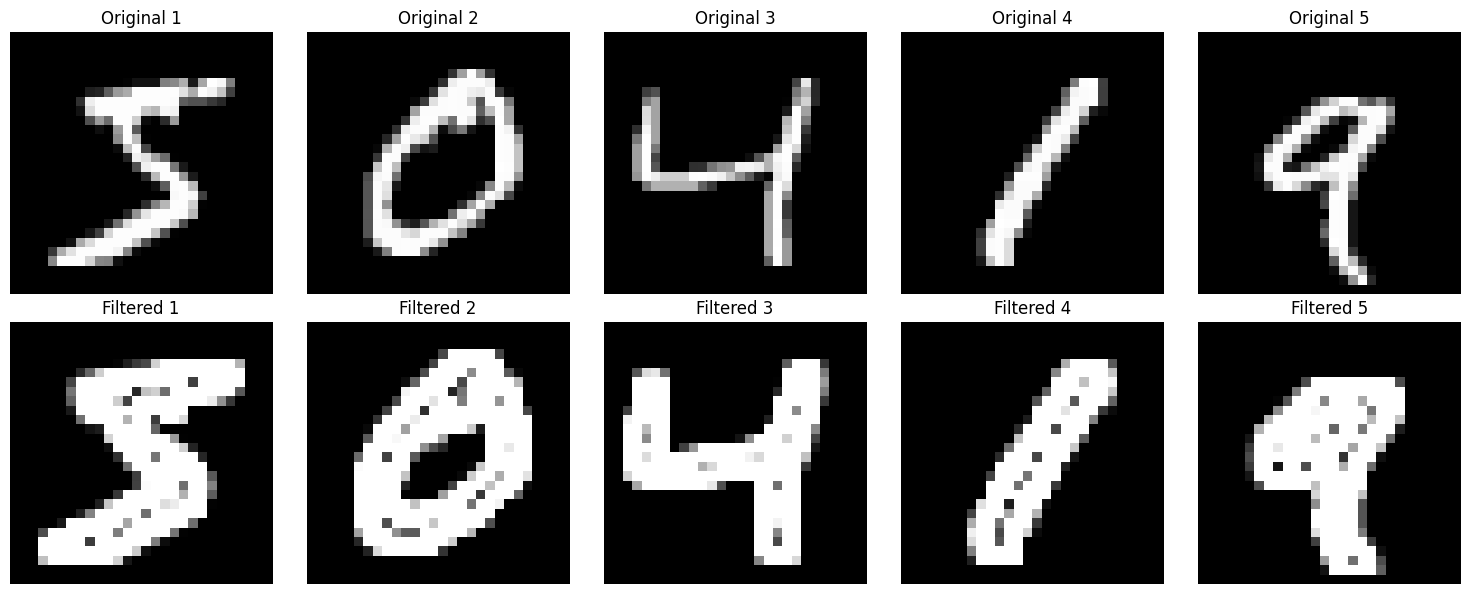

In [61]:
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets

# 필요한 디렉토리 생성
!mkdir -p /content/CUDADigitFilter/data/mnist
!mkdir -p /content/CUDADigitFilter/results/filtered_images

def download_mnist():
    # torchvision을 통해 MNIST 데이터셋 다운로드
    mnist_train = datasets.MNIST(root='/content/CUDADigitFilter/data',
                               train=True, download=True)

    # 이미지 데이터를 바이너리 파일로 저장
    output_file = '/content/CUDADigitFilter/data/mnist/train-images-idx3-ubyte'

    # 헤더 정보 (magic number, 이미지 수, 행, 열)
    header = np.array([2051, len(mnist_train), 28, 28], dtype='>i4')

    with open(output_file, 'wb') as f:
        header.tofile(f)
        # 이미지 데이터 저장
        for img, _ in mnist_train:
            np.array(img).astype(np.uint8).tofile(f)

    print("MNIST data is ready")

# MNIST 데이터 다운로드
!pip install torchvision
download_mnist()

def show_results(num_images=5):
    # 원본 이미지 로드
    with open('/content/CUDADigitFilter/data/mnist/train-images-idx3-ubyte', 'rb') as f:
        # 헤더 스킵
        f.read(16)
        # 이미지 읽기
        original_images = np.frombuffer(f.read(28*28*num_images),
                                      dtype=np.uint8).reshape(num_images, 28, 28)

    # CUDA 프로그램 실행
    !cd /content/CUDADigitFilter && ./mnist_filter --input data/mnist/train-images-idx3-ubyte --output results/filtered_images --filter sobel --num-images {num_images}

    # 필터링된 이미지 로드
    filtered_images = []
    for i in range(num_images):
        img_path = f'/content/CUDADigitFilter/results/filtered_images/image_{i}.pgm'
        if os.path.exists(img_path):
            img = plt.imread(img_path)
            filtered_images.append(img)
        else:
            print(f"Warning: Cannot find filtered image at {img_path}")

    if not filtered_images:
        print("No filtered images found!")
        return

    # 결과 시각화
    plt.figure(figsize=(15, 6))

    # 원본 이미지 표시
    for i in range(num_images):
        plt.subplot(2, num_images, i+1)
        plt.imshow(original_images[i], cmap='gray')
        plt.axis('off')
        plt.title(f'Original {i+1}')

    # 필터링된 이미지 표시
    for i in range(len(filtered_images)):
        plt.subplot(2, num_images, num_images+i+1)
        plt.imshow(filtered_images[i], cmap='gray')
        plt.axis('off')
        plt.title(f'Filtered {i+1}')

    plt.tight_layout()
    plt.show()

# CUDA 프로그램이 제대로 빌드되었는지 확인
!cd /content/CUDADigitFilter && ls -l mnist_filter

# 결과 표시
show_results(5)


Applying sobel filter...
[INFO] Applying sobel filter...
[INFO] Saving processed images...
[INFO] Processing completed successfully


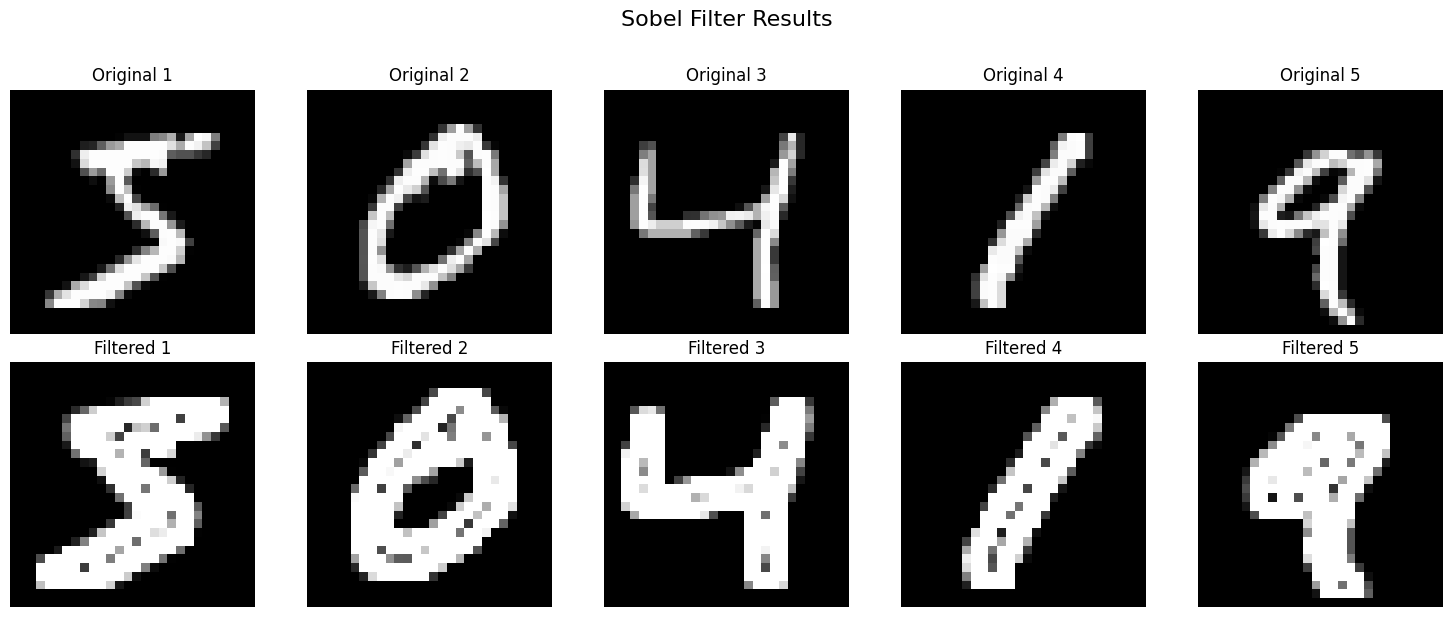


Applying gaussian filter...
[INFO] Applying gaussian filter...
[INFO] Saving processed images...
[INFO] Processing completed successfully


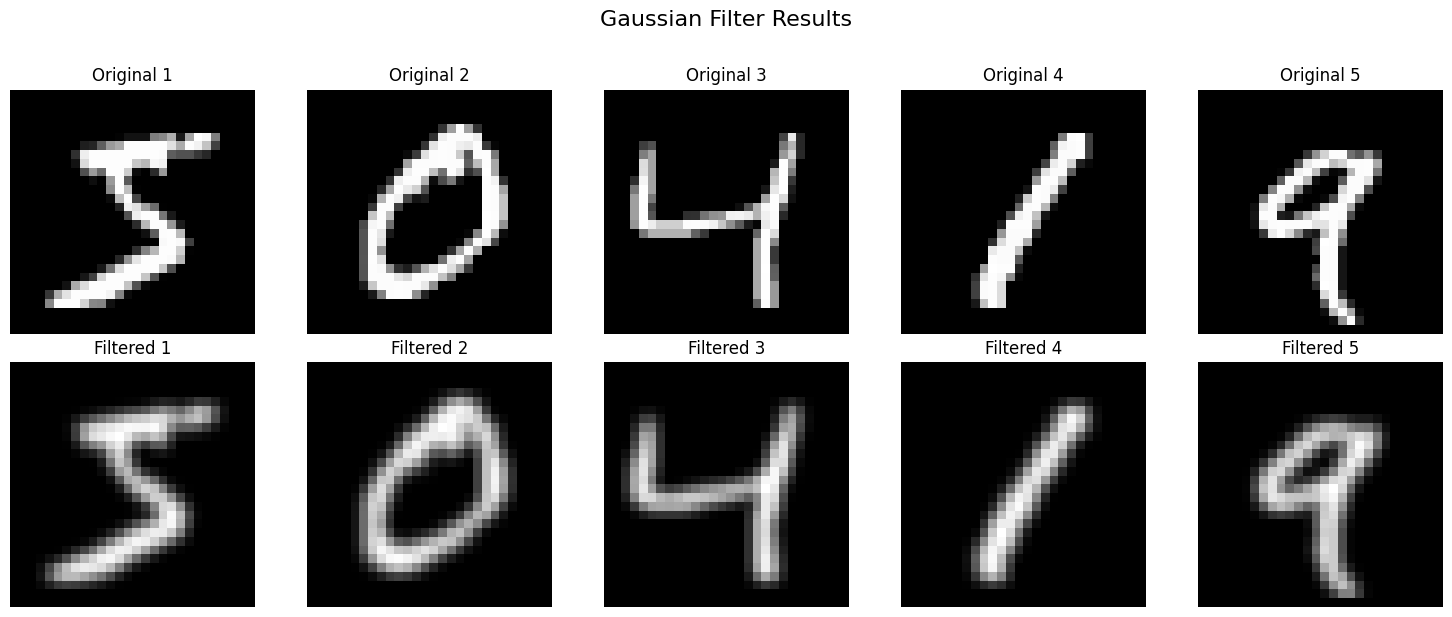


Applying sharpen filter...
[INFO] Applying sharpen filter...
[INFO] Saving processed images...
[INFO] Processing completed successfully


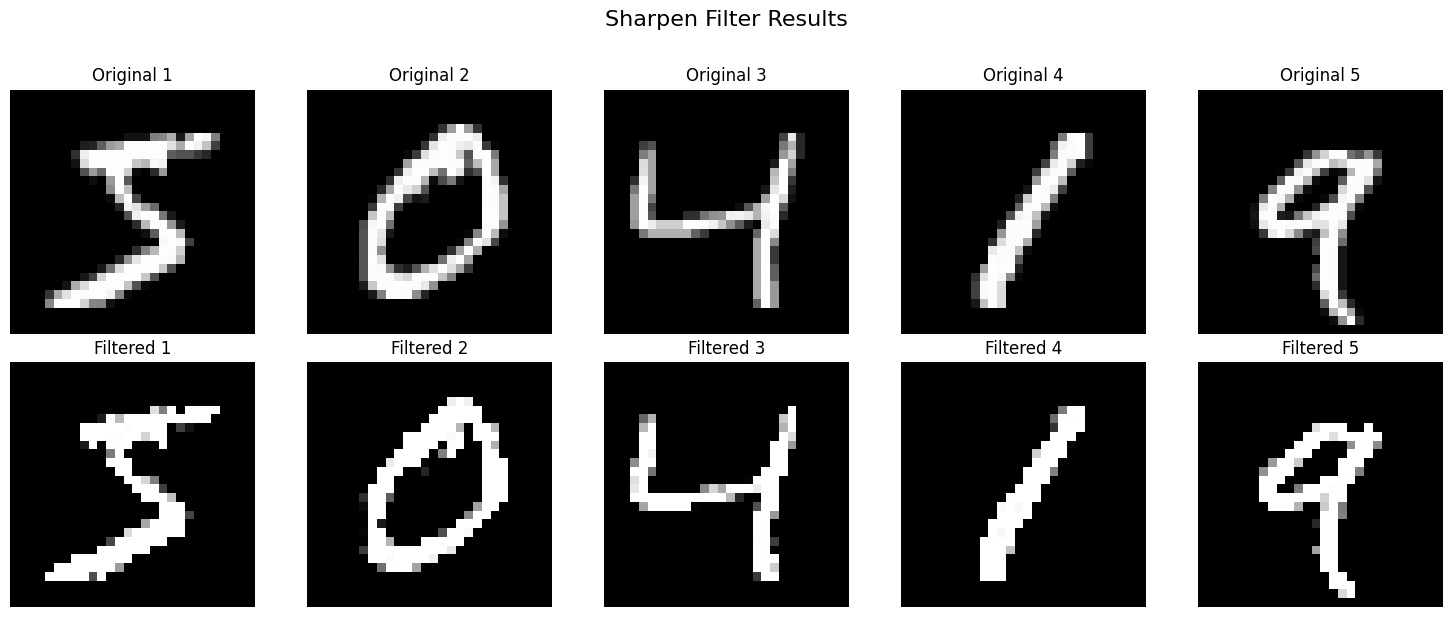

In [62]:
def apply_and_show_filter(filter_type, num_images=5):
    # CUDA 프로그램 실행
    output_dir = f'/content/CUDADigitFilter/results/{filter_type}_images'
    !mkdir -p {output_dir}

    !cd /content/CUDADigitFilter && ./mnist_filter \
        --input data/mnist/train-images-idx3-ubyte \
        --output {output_dir} \
        --filter {filter_type} \
        --num-images {num_images}

    # 원본 이미지 로드
    with open('/content/CUDADigitFilter/data/mnist/train-images-idx3-ubyte', 'rb') as f:
        # 헤더 스킵
        f.read(16)
        # 이미지 읽기
        original_images = np.frombuffer(f.read(28*28*num_images),
                                      dtype=np.uint8).reshape(num_images, 28, 28)

    # 필터링된 이미지 로드
    filtered_images = []
    for i in range(num_images):
        img_path = f'{output_dir}/image_{i}.pgm'
        if os.path.exists(img_path):
            img = plt.imread(img_path)
            filtered_images.append(img)
        else:
            print(f"Warning: Cannot find filtered image at {img_path}")

    if not filtered_images:
        print(f"No filtered images found for {filter_type} filter!")
        return

    # 결과 시각화
    plt.figure(figsize=(15, 6))
    plt.suptitle(f'{filter_type.capitalize()} Filter Results', y=1.02, fontsize=16)

    # 원본 이미지 표시
    for i in range(num_images):
        plt.subplot(2, num_images, i+1)
        plt.imshow(original_images[i], cmap='gray')
        plt.axis('off')
        plt.title(f'Original {i+1}')

    # 필터링된 이미지 표시
    for i in range(len(filtered_images)):
        plt.subplot(2, num_images, num_images+i+1)
        plt.imshow(filtered_images[i], cmap='gray')
        plt.axis('off')
        plt.title(f'Filtered {i+1}')

    plt.tight_layout()
    plt.show()

# MNIST 데이터가 없으면 다운로드
if not os.path.exists('/content/CUDADigitFilter/data/mnist/train-images-idx3-ubyte'):
    mnist_train = datasets.MNIST(root='/content/CUDADigitFilter/data',
                               train=True, download=True)

    # 이미지 데이터를 바이너리 파일로 저장
    output_file = '/content/CUDADigitFilter/data/mnist/train-images-idx3-ubyte'

    # 헤더 정보 (magic number, 이미지 수, 행, 열)
    header = np.array([2051, len(mnist_train), 28, 28], dtype='>i4')

    with open(output_file, 'wb') as f:
        header.tofile(f)
        # 이미지 데이터 저장
        for img, _ in mnist_train:
            np.array(img).astype(np.uint8).tofile(f)

# 각 필터 적용 및 결과 표시
filters = ['sobel', 'gaussian', 'sharpen']
num_images = 5

for filter_type in filters:
    print(f"\nApplying {filter_type} filter...")
    apply_and_show_filter(filter_type, num_images)